In [1]:
!pip install diffusers accelerate controlnet_hinter -q

In [10]:
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline
import torch
from PIL import Image
import controlnet_hinter
import matplotlib.pyplot as plt

In [3]:
CONTROLNET_MAPPING = {
    "canny_edge": {
        "model_id": "lllyasviel/sd-controlnet-canny",
        "hinter": controlnet_hinter.hint_canny
    },
    "pose": {
        "model_id": "lllyasviel/sd-controlnet-openpose",
        "hinter": controlnet_hinter.hint_openpose
    }
}

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
controlnet_type = "canny_edge"

sd_id = "runwayml/stable-diffusion-v1-5"
# sd_id = "digiplay/Juggernaut_final"

controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MAPPING[controlnet_type]["model_id"],
    torch_dtype=torch.float16
)
controlnet = controlnet.to(device)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_id,
    controlnet=controlnet,
    torch_dtype=torch.float16
)
pipe = pipe.to(device)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
!wget -O yuuki.jpg "https://image.cdn2.seaart.ai/2023-07-08/42970891165765/3dea9ccad061433fe832cbdb0b4fd3b3d8253c7d_high.webp"

--2024-07-28 12:26:24--  https://image.cdn2.seaart.ai/2023-07-08/42970891165765/3dea9ccad061433fe832cbdb0b4fd3b3d8253c7d_high.webp
Resolving image.cdn2.seaart.ai (image.cdn2.seaart.ai)... 34.104.38.56, 2600:1900:4110:b7c::
Connecting to image.cdn2.seaart.ai (image.cdn2.seaart.ai)|34.104.38.56|:443... connected.
HTTP request sent, awaiting response... 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


200 OK
Length: 335332 (327K) [image/webp]
Saving to: 'yuuki.jpg'

yuuki.jpg           100%[===================>] 327.47K  --.-KB/s    in 0.05s   

2024-07-28 12:26:24 (6.90 MB/s) - 'yuuki.jpg' saved [335332/335332]



In [19]:
def crop_man(image, target_size):
    target_width, target_height = target_size
    width, height = image.size
    if width > height:
        left = (width - height) // 2
        top = 0
        right = width - left
        bottom = height
    else:
        top = (height - width) // 2
        left = 0
        bottom = height - top
        right = width
    cropped_image = image.crop((left, top, right, bottom))
    resized_image = cropped_image.resize((target_width, target_height), Image.Resampling.LANCZOS)
    return resized_image

def show_diff(old_image):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    ax[0, 0].imshow(old_image)
    ax[0, 0].set_title("Original Image")
    ax[0, 0].axis('off')
    
    for i in range(3):
        new_image = pipe(
            prompt=prompt,
            width=512,
            height=512,
            negative_prompt=negative_prompt,
            image=control_image,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            guidance_scale=guidance_scale,
            num_inference=no_of_steps
        ).images[0]
        row = (i + 1) // 2
        col = (i + 1) % 2
        ax[row, col].imshow(new_image)
        ax[row, col].set_title(f"Generated Image {i + 1}")
        ax[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
from diffusers.utils import load_image
prompt = "A beautiful anime character with blonde hair and blue eyes"
negative_prompt = "lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"

no_of_steps = 20
guidance_scale = 7.0
controlnet_conditioning_scale = 1.0

image = load_image("yuuki.jpg")
image = crop_man(image, (512, 512))
control_image = CONTROLNET_MAPPING[controlnet_type]["hinter"](image)

new_images = pipe(
    prompt=prompt,
    width=512,
    height=512,
    negative_prompt=negative_prompt,
    image=control_image,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    guidance_scale=guidance_scale,
    num_inference=no_of_steps
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

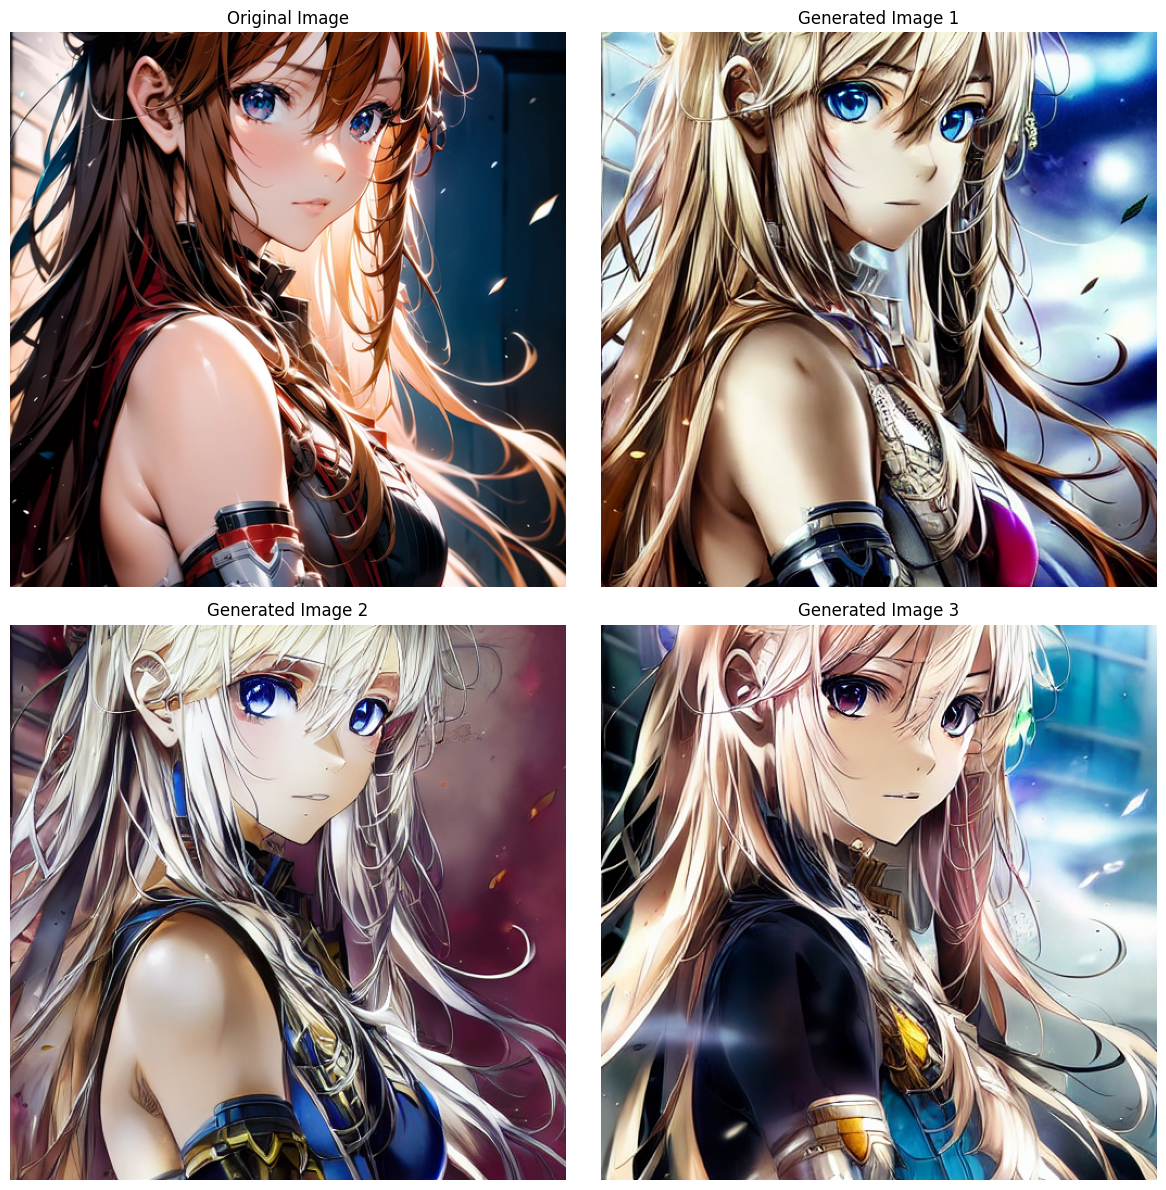

In [20]:
show_diff(image)